In [51]:
%%javascript
/**********************************************************************************************
Known Mathjax Issue with Chrome - a rounding issue adds a border to the right of mathjax markup
https://github.com/mathjax/MathJax/issues/1300
A quick hack to fix this based on stackoverflow discussions: 
http://stackoverflow.com/questions/34277967/chrome-rendering-mathjax-equations-with-a-trailing-vertical-line
**********************************************************************************************/

$('.math>span').css("border-left-color","transparent")

<IPython.core.display.Javascript object>

In [52]:
%reload_ext autoreload
%autoreload 2

# MIDS - w261 Machine Learning At Scale
__Course Lead:__ Dr James G. Shanahan (__email__ Jimi via  James.Shanahan _AT_ gmail.com)

## Assignment - HW10


---
__Name:__  Alex Smith  
__Class:__ MIDS W261 (Summer 2016 Group 2)     
__Email:__ aksmith@iSchool.Berkeley.edu     
__Week:__  10

***
# Table of Contents <a name="TOC"></a> 

1.  [HW Introduction](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
    10.0.  [Short Answer Questions](#HW10.0)    
    10.1.  [Word Count plus sorting](#HW10.1)   
    10.2.  [MLlib-centric Kmeans](#HW10.2)    
    10.3.  [Homegrown KMeans in Spark](#HW10.3)    
    10.4.  [Making Homegrown KMeans more efficient](#HW10.4)  
    10.5.  [OPTIONAL Weighted KMeans](#HW10.5)  
    10.6.  [OPTIONAL Linear Regression](#HW10.6)  
    10.7.  [OPTIONAL Error surfaces](#HW10.7)


<a name="1">
# 1 Instructions
[Back to Table of Contents](#TOC)
* Homework submissions are due by Tueday, 07/28/2016 at 11AM (West Coast Time).


* Prepare a single Jupyter notebook, please include questions, and question numbers in the questions and in the responses.
Submit your homework notebook via the following form:

   + [Submission Link - Google Form](
https://docs.google.com/forms/d/1ZOr9RnIe_A06AcZDB6K1mJN4vrLeSmS2PD6Xm3eOiis/viewform?usp=send_form 
)


### Documents:
* IPython Notebook, published and viewable online.
* PDF export of IPython Notebook.
    
<a name="2">
# 2 Useful References
[Back to Table of Contents](#TOC)

* Karau, Holden, Konwinski, Andy, Wendell, Patrick, & Zaharia, Matei. (2015). Learning Spark: Lightning-fast big data analysis. Sebastopol, CA: O’Reilly Publishers.
* Hastie, Trevor, Tibshirani, Robert, & Friedman, Jerome. (2009). The elements of statistical learning: Data mining, inference, and prediction (2nd ed.). Stanford, CA: Springer Science+Business Media. (Download for free [here](http://statweb.stanford.edu/~tibs/ElemStatLearn/printings/ESLII_print10.pdf))

<a name="3">
# 3 HW Problems
[Back to Table of Contents](#TOC)

In [3]:
import os
import sys

import pyspark
from pyspark.sql import SQLContext

# We can give a name to our app (to find it in Spark WebUI) and configure execution mode
# In this case, it is local multicore execution with "local[*]"
app_name = "example-logs"
master = "local[*]"
conf = pyspark.SparkConf().setAppName(app_name).setMaster(master)
sc = pyspark.SparkContext(conf=conf)
sqlContext = SQLContext(sc)


print sc
print sqlContext

In [2]:
# sto shutdown an existing Spark cluster
sc.stop()

***
<a name="HW10.0"></a><h2 style="color:darkblue"> HW10.0: Short answer questions </h2>
[Back to Table of Contents](#TOC)


__What is Apache Spark and how is it different to Apache Hadoop? __

Apache Spark and Apache Hadoop are actually quite similar. They both can perform a lot of the same tasks. Apache Spark does not have its own filesystem (it can use Hadoop's file system). Spark is also lazily evaluated. This means that the program does not start working until it must (transformations wait to be executed until an action is called). Probably the biggest difference is that Spark processes the data in memory and keeps it there. Hadoop sends the memory back to disk after analyzing it. This means that you want your Spark cluster to have a large amount of memory, enough to hold your big data.
*[Useful reference](https://www.xplenty.com/blog/2014/11/apache-spark-vs-hadoop-mapreduce/)*
<hr>

__Fill in the blanks:
Spark API consists of interfaces to develop applications based on it in Java, __ <span style="color:orange">Python, and Scala</span>__ languages (list languages). __

<hr>

__Using Spark, resource management can be done either in a single server instance or using a framework such as Mesos or <span style="color:orange">YARN</span> in a distributed manner. __

<hr>

__What is an RDD and show a fun example of creating one and bringing the first element back to the driver program. __

An RDD is a **R**esilient **D**istributed **D**ataset. In Spark, all work is expressed in terms of RDDs. Spark automatically distributes the data from the RDDs across your cluster and performs the analysis on them. (*Source: Async 10.5*)


In [5]:
# create an RDD that is a simple list
rdd_ex = sc.parallelize(range(10))
print "The first item of the RDD is",rdd_ex.map(lambda x:  "Hi there, person "+str(x)).first()

 The first item of the RDD is Hi there, person 0


***
<a name="HW10.1"> <h2 style="color:darkgreen">HW10.1 WordCount plus sorting </h2>
[Back to Table of Contents](#TOC)

The following notebooks will be useful to jumpstart this collection of Homework exercises:


* [Example Notebook with Debugging tactics in Spark](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/jqjllp8kmf1eolk/WordCountDebugging-Example.ipynb)
* [Word Count Quiz](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/vgmpivsi4rvqz0s/WordCountQuiz.ipynb)
* [Work Count Solution](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/dxv3dmp1vluuo8i/WordCountQuiz-Solution.ipynb)

---
In Spark write the code to count how often each word appears in a text document (or set of documents). Please use this homework document (with no solutions in it) as a the example document to run an experiment.  Report the following: 
* provide a sorted list of tokens in decreasing order of frequency of occurence limited to [top 20 most frequent only] and [bottom 10 least frequent]. 


__OPTIONAL__ 
Feel free to do a secondary sort where words with the same frequncy are sorted alphanumerically increasing. Plseas refer to the [following notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/uu5afr3ufpm9fy8/SecondarySort.ipynb)
 for examples of secondary sorts in Spark. Please provide the following [top 20 most frequent terms only] and [bottom 10 least frequent terms]

__NOTE__ [Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__

### Create the file for which we'll complete the word count
We use an excerpt from [Hans Christrian Anderson's fairytales](http://www.gutenberg.org/cache/epub/1597/pg1597.txt). We do this to meet the requirement that HW submission should comprise just one notebook. We don't want to do the count on this notebook because this notebook will be changing as we complete each question. 

In [7]:
%%writefile anderson_sample.txt

"""
THE EMPEROR'S NEW CLOTHES
Many years ago, there was an Emperor, who was so excessively fond of
new clothes, that he spent all his money in dress. He did not trouble
himself in the least about his soldiers; nor did he care to go either to
the theatre or the chase, except for the opportunities then afforded him
for displaying his new clothes. He had a different suit for each hour of
the day; and as of any other king or emperor, one is accustomed to say,
"he is sitting in council," it was always said of him, "The Emperor is
sitting in his wardrobe."

Time passed merrily in the large town which was his capital; strangers
arrived every day at the court. One day, two rogues, calling themselves
weavers, made their appearance. They gave out that they knew how to
weave stuffs of the most beautiful colors and elaborate patterns, the
clothes manufactured from which should have the wonderful property of
remaining invisible to everyone who was unfit for the office he held, or
who was extraordinarily simple in character.

"These must, indeed, be splendid clothes!" thought the Emperor. "Had I
such a suit, I might at once find out what men in my realms are unfit
for their office, and also be able to distinguish the wise from the
foolish! This stuff must be woven for me immediately." And he caused
large sums of money to be given to both the weavers in order that they
might begin their work directly.

So the two pretended weavers set up two looms, and affected to work very
busily, though in reality they did nothing at all. They asked for the
most delicate silk and the purest gold thread; put both into their own
knapsacks; and then continued their pretended work at the empty looms
until late at night.

"I should like to know how the weavers are getting on with my cloth,"
said the Emperor to himself, after some little time had elapsed; he was,
however, rather embarrassed, when he remembered that a simpleton, or
one unfit for his office, would be unable to see the manufacture. To be
sure, he thought he had nothing to risk in his own person; but yet, he
would prefer sending somebody else, to bring him intelligence about the
weavers, and their work, before he troubled himself in the affair. All
the people throughout the city had heard of the wonderful property the
cloth was to possess; and all were anxious to learn how wise, or how
ignorant, their neighbors might prove to be.

"I will send my faithful old minister to the weavers," said the Emperor
at last, after some deliberation, "he will be best able to see how the
cloth looks; for he is a man of sense, and no one can be more suitable
for his office than he is."

So the faithful old minister went into the hall, where the knaves were
working with all their might, at their empty looms. "What can be the
meaning of this?" thought the old man, opening his eyes very wide. "I
cannot discover the least bit of thread on the looms." However, he did
not express his thoughts aloud.

The impostors requested him very courteously to be so good as to come
nearer their looms; and then asked him whether the design pleased
him, and whether the colors were not very beautiful; at the same time
pointing to the empty frames. The poor old minister looked and looked,
he could not discover anything on the looms, for a very good reason,
viz: there was nothing there. "What!" thought he again. "Is it possible
that I am a simpleton? I have never thought so myself; and no one must
know it now if I am so. Can it be, that I am unfit for my office? No,
that must not be said either. I will never confess that I could not see
the stuff."

"Well, Sir Minister!" said one of the knaves, still pretending to work.
"You do not say whether the stuff pleases you."

"Oh, it is excellent!" replied the old minister, looking at the loom
through his spectacles. "This pattern, and the colors, yes, I will tell
the Emperor without delay, how very beautiful I think them."

"We shall be much obliged to you," said the impostors, and then they
named the different colors and described the pattern of the pretended
stuff. The old minister listened attentively to their words, in order
that he might repeat them to the Emperor; and then the knaves asked for
more silk and gold, saying that it was necessary to complete what
they had begun. However, they put all that was given them into their
knapsacks; and continued to work with as much apparent diligence as
before at their empty looms.

The Emperor now sent another officer of his court to see how the men
were getting on, and to ascertain whether the cloth would soon be
ready. It was just the same with this gentleman as with the minister;
he surveyed the looms on all sides, but could see nothing at all but the
empty frames.

"Does not the stuff appear as beautiful to you, as it did to my lord the
minister?" asked the impostors of the Emperor's second ambassador; at
the same time making the same gestures as before, and talking of the
design and colors which were not there.

"I certainly am not stupid!" thought the messenger. "It must be, that I
am not fit for my good, profitable office! That is very odd; however, no
one shall know anything about it." And accordingly he praised the stuff
he could not see, and declared that he was delighted with both colors
and patterns. "Indeed, please your Imperial Majesty," said he to his
sovereign when he returned, "the cloth which the weavers are preparing
is extraordinarily magnificent."

The whole city was talking of the splendid cloth which the Emperor had
ordered to be woven at his own expense.

And now the Emperor himself wished to see the costly manufacture, while
it was still in the loom. Accompanied by a select number of officers of
the court, among whom were the two honest men who had already admired
the cloth, he went to the crafty impostors, who, as soon as they were
aware of the Emperor's approach, went on working more diligently than
ever; although they still did not pass a single thread through the
looms.

"Is not the work absolutely magnificent?" said the two officers of the
crown, already mentioned. "If your Majesty will only be pleased to look
at it! What a splendid design! What glorious colors!" and at the same
time they pointed to the empty frames; for they imagined that everyone
else could see this exquisite piece of workmanship.
"""

Overwriting anderson_sample.txt


### Perform the wordcount analysis on it

In [21]:
# read in the file
rdd_text = sc.textFile('anderson_sample.txt')
print "The file has", rdd_text.count(),"lines"

The file has 118 lines


In [66]:
# count the words
# first split by spaces
# then emit each word with a count of 1
# then reduce by the key, which is the word
# finally sum the word counts
counts = rdd_text.flatMap(lambda line: line.split())\
            .map(lambda word: (word,1))\
            .reduceByKey(lambda a,b: a+b)

# print out a sample
print "Sample word counts:", counts.collect()[0:10]

Sample word counts: [(u'weavers', 4), (u'neighbors', 1), (u'all', 6), (u'held,', 1), (u'gold', 1), (u'able', 2), (u'pleases', 1), (u'patterns.', 1), (u'What', 2), (u'patterns,', 1)]


### Sort the wordcounts

In [20]:
# reverse the key, value pair
# sort by key
# and then re-reverse the key,value 
# pair so that the word comes first
sorted_counts = counts.map(lambda x: (x[1],x[0]))\
                        .sortByKey(False)\
                        .map(lambda x: (x[1],x[0]))\
                        .collect()
        
# show the top 20 most frequent words
TOP = 20
print "The top 20 words are:"
for i in range(TOP):
    print sorted_counts[i]
    
# show the bottom 10 words
BOTTOM = 10
print "\n"
print "*~*~*~*~*"
print "\n"
print "The bottom 10 words are:"
for i in range(1,BOTTOM+1):
    print sorted_counts[-i]

The top 20 words are:
(u'the', 88)
(u'to', 38)
(u'and', 25)
(u'he', 23)
(u'of', 22)
(u'for', 15)
(u'be', 15)
(u'at', 15)
(u'not', 14)
(u'was', 14)
(u'his', 14)
(u'that', 14)
(u'their', 13)
(u'in', 13)
(u'I', 11)
(u'they', 10)
(u'as', 10)
(u'a', 9)
(u'said', 8)
(u'it', 8)


*~*~*~*~*


The bottom 10 words are:
(u'was,', 1)
(u'once', 1)
(u'without', 1)
(u'spent', 1)
(u'courteously', 1)
(u'foolish!', 1)
(u'ascertain', 1)
(u'"the', 1)
(u'reason,', 1)
(u'"Had', 1)


<a name="HW10.1.1"><h2 style="color:darkgreen">HW10.1.1 </h2>
[Back to Table of Contents](#TOC)

Modify the above word count code to count words that begin with lower case letters (a-z) and report your findings. Again sort the output words in decreasing order of frequency.


### Read in the data

In [22]:
# read in the file
rdd_text = sc.textFile('anderson_sample.txt')
print "The file has", rdd_text.count(),"lines"

The file has 118 lines


In [71]:
# write a function that splits
# and returns only the lowercase words
def lowerSplit(text):
    
    # split the text
    text = text.split()
    
    # create a new array to hold
    # all of the lower-case only
    # words
    new_text = []
    
    # loop through the text
    for word in text:
        
        # check to make sure that we
        # actually have a word
        if len(word) > 0:
        
            # if the first letter is a letter
            if word[0].isalpha:
                
                # if the first letter is lowercase
                if word[0]==word[0].lower():
                    
                    # append the word to our list
                    new_text.append(word)
            
    return new_text

# count the words
# first split by spaces
# then emit each word with a count of 1
# then reduce by the key, which is the word
# finally sum the word counts
counts = rdd_text.flatMap(lambda line: lowerSplit(line))\
            .map(lambda word: (word,1))\
            .reduceByKey(lambda a,b: a+b)

# print out a sample
print "Sample word counts:", counts.collect()[0:10]

Sample word counts: [(u'weavers', 4), (u'neighbors', 1), (u'all', 6), (u'held,', 1), (u'gold', 1), (u'able', 2), (u'pleases', 1), (u'patterns.', 1), (u'returned,', 1), (u'patterns,', 1)]


### Sort the wordcounts by frequency

In [72]:
# reverse the key, value pair
# sort by key
# and then re-reverse the key,value 
# pair so that the word comes first
sorted_counts = counts.map(lambda x: (x[1],x[0]))\
                        .sortByKey(False)\
                        .map(lambda x: (x[1],x[0]))\
                        .collect()
        
# show the top 20 most frequent words
TOP = 20
print "The top 20 words are:"
for i in range(TOP):
    print sorted_counts[i]
    
# show the bottom 10 words
BOTTOM = 10
print "\n"
print "*~*~*~*~*"
print "\n"
print "The bottom 10 words are:"
for i in range(1,BOTTOM+1):
    print sorted_counts[-i]

The top 20 words are:
(u'the', 88)
(u'to', 38)
(u'and', 25)
(u'he', 23)
(u'of', 22)
(u'for', 15)
(u'be', 15)
(u'at', 15)
(u'not', 14)
(u'was', 14)
(u'his', 14)
(u'that', 14)
(u'their', 13)
(u'in', 13)
(u'they', 10)
(u'as', 10)
(u'a', 9)
(u'it', 8)
(u'said', 8)
(u'had', 7)


*~*~*~*~*


The bottom 10 words are:
(u'was,', 1)
(u'"Had', 1)
(u'once', 1)
(u'without', 1)
(u'spent', 1)
(u'courteously', 1)
(u'ascertain', 1)
(u'"the', 1)
(u'prove', 1)
(u'weave', 1)


<a name="HW10.2"> <h2 style="color:darkblue"> HW10.2: MLlib-centric KMeans</h2>
[Back to Table of Contents](#TOC)

Using the following  MLlib-centric KMeans code snippet: 

<pre>
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt


# Load and parse the data
# NOTE  kmeans_data.txt is available here 
#          https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 
data = sc.textFile("kmeans_data.txt")  
parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10,
        runs=10, initializationMode="random")

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

# Save and load model
clusters.save(sc, "myModelPath")
sameModel = KMeansModel.load(sc, "myModelPath")

</pre>

__NOTE__ <p> The  __kmeans_data.txt__ is available here https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 

__TASKS__
* Run this code snippet and list the clusters that your find.
* compute the Within Set Sum of Squared Errors for the found clusters. Comment on your findings.

### Load in the data

In [75]:
from numpy import array

# load and parse the data
# NOTE  kmeans_data.txt is available here 
#          https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 
data = sc.textFile("kmeans_data.txt")  
parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

# print out the parsed data
print "Parsed data:", parsedData.collect()

Parsed data: [array([ 0.,  0.,  0.]), array([ 0.1,  0.1,  0.1]), array([ 0.2,  0.2,  0.2]), array([ 9.,  9.,  9.]), array([ 9.1,  9.1,  9.1]), array([ 9.2,  9.2,  9.2])]


In [78]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from math import sqrt

# set the number of clusters and the number of runs
NUM_CLUSTERS = 2
MAX_ITERATIONS = 10
RUNS = 10

# build the model (cluster the data)
clusters = KMeans.train(parsedData, NUM_CLUSTERS, maxIterations=MAX_ITERATIONS,
        runs=RUNS, initializationMode="random")

# evaluate clustering by computing Within Set Sum 
# of Squared Errors the WSSSE is simply the distance
# between each point and its predicted centroid
def error(point):
    
    # predict the centroid from the model
    center = clusters.centers[clusters.predict(point)]
    
    # return the square root of the squared distance
    # between each point and its predicted centroid
    return sqrt(sum([x**2 for x in (point - center)]))

# calculate the WSSSE for each point and sum them 
# all together
WSSSE = parsedData.map(lambda point: error(point))\
                    .reduce(lambda x, y: x + y)
    
# print out results from the squared error
print("Within Set Sum of Squared Error = " + str(WSSSE))

# save and load model
clusters.save(sc, "kmeans_model")
clusters = KMeansModel.load(sc, "kmeans_model")

Within Set Sum of Squared Error = 0.692820323028


<a name="HW10.3"><h2 style="color:darkgreen"> HW10.3: MLLib KMeans in Spark </h2>
[Back to Table of Contents](#TOC)

Download the following KMeans [notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb).

Generate 3 clusters with 100 (one hundred) data points per cluster (using the code provided). Plot the data.
Then run **MLlib's** Kmean implementation on this data  and report your results as follows:

* plot the resulting clusters after 1 iteration, 10 iterations, after 20 iterations, after 100 iterations.
* in each plot please report the Within Set Sum of Squared Errors for the found clusters (as part of the title WSSSE). Comment on the progress of this measure as  the KMEans algorithms runs for more iterations. Then plot the WSSSE as a function of the iteration (1, 10, 20, 30, 40, 50, 100).



### Create the data

In [79]:
import numpy as np

# set the size of the clusters
size1 = size2 = size3 = 100

# generate the three samples and append 
# to a single list
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)

# randomlize data
data = data[np.random.permutation(size1+size2+size3),]

# save the data to a local file
np.savetxt('data.csv',data,delimiter = ',')

print "Data created."

Data created.


### Visualize the data

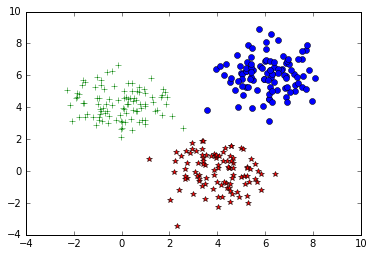

In [84]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot each sample in its own color
plt.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red')
plt.plot(samples2[:, 0], samples2[:, 1],'o',color = 'blue')
plt.plot(samples3[:, 0], samples3[:, 1],'+',color = 'green')
plt.show()

### Load in and parse the data

In [4]:
import numpy as np

# load in the data file
data = sc.textFile("data.csv")

# parse the data by turning it into a list of floats
parsedData = data.map(lambda line: np.array([float(x) for x in line.split(',')])).cache()

# create the data in list form for plotting
data = np.array(parsedData.collect())

print "Data loaded."

Data loaded.


### Function to plot the data and the centroid

In [6]:
%matplotlib inline

# import our libraries
import matplotlib.pyplot as plt

def plotKMeans(centroids, data, \
               data_color = 'blue',\
               centroid_color = 'red'):
    """takes the centroid locations and the 
    data that we want to plot and plots the 
    points with the centroids in a different
    color"""    
    
    # plot the data
    plt.plot(data[:,0], data[:,1],'.', \
             color = data_color)
    
    # plot the centroids
    plt.plot(centroids[:,0], centroids[:,1], \
             '*', markersize =10, color = centroid_color)
    
    # show the plot
    plt.show()

### Function to calculate the WSSSE

In [12]:
# evaluate clustering by computing Within Set Sum 
# of Squared Errors the WSSSE is simply the distance
# between each point and its predicted centroid
def wsseError(point,clusters):
    
    # predict the centroid from the model
    center = clusters.centers[clusters.predict(point)]
    
    # return the square root of the squared distance
    # between each point and its predicted centroid
    return sqrt(sum([x**2 for x in (point - center)]))

### Use the Spark machine learning library to compute the centroids

Iteration 1
With-in Set Sum of Squared Errors: 723.27290681
Centeroids:
[[ 1.44051463  2.41595155]
 [ 5.68735101  3.43692136]
 [ 6.19630882  6.87657625]]


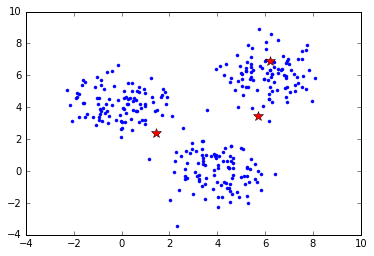

Iteration 10
With-in Set Sum of Squared Errors: 394.145437822
Centeroids:
[[-0.06737074  4.22687513]
 [ 4.01283697 -0.02271581]
 [ 6.10388592  6.04617728]]


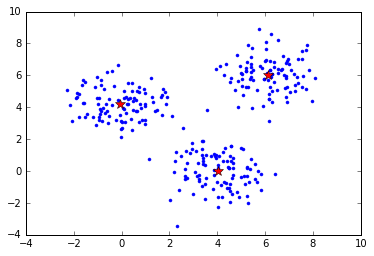

Iteration 20
With-in Set Sum of Squared Errors: 394.145437822
Centeroids:
[[-0.06737074  4.22687513]
 [ 4.01283697 -0.02271581]
 [ 6.10388592  6.04617728]]


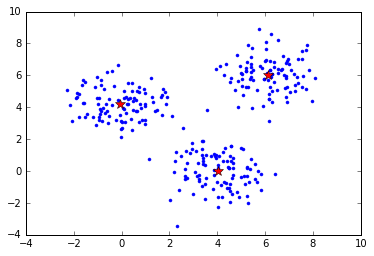

Iteration 100
With-in Set Sum of Squared Errors: 394.145437822
Centeroids:
[[-0.06737074  4.22687513]
 [ 4.01283697 -0.02271581]
 [ 6.10388592  6.04617728]]


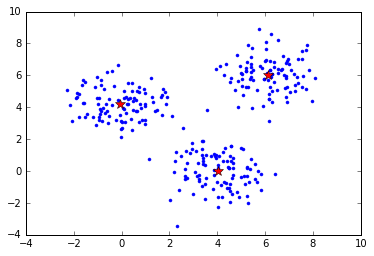

In [18]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from math import sqrt
import numpy as np

# set the number of iterations
ITERATIONS = 100

# set the interesting iterations
INTEREST = [1,10,20,100]

# set the iterations we want
# to record errors for
ERROR_INTEREST = [1, 10, 20, 30, 40, 50, 100]

# create a list to hold our 
# error for each iterations
errors = []

# set the current iteration
iteration = 0 

# set the number of runs and iterations
# for each of our iterations
# set the number of clusters and the number of runs
NUM_CLUSTERS = 3
MAX_ITERATIONS = 1
RUNS = 1

# while the iteration is less than 
# the number of iterations
while iteration <= ITERATIONS:
    
    # if this is the first iteration,
    # then we use a random initalization
    if iteration == 0:
    
        # build the model (cluster the data)
        clusters = KMeans.train(parsedData, NUM_CLUSTERS, \
                                maxIterations=MAX_ITERATIONS,\
                                initializationSteps=RUNS,\
                                runs=RUNS, initializationMode="random")
    
    # otherwise build the model based on the previous model
    else: 
        
        # build the model (cluster the data)
        clusters = KMeans.train(parsedData, NUM_CLUSTERS, \
                                maxIterations=MAX_ITERATIONS,\
                                runs=RUNS, initialModel=clusters)
    # icrement the iteration 
    iteration = iteration + 1
    
    # grab the centroids
    centroids = np.array(clusters.centers)
    
    # calculate the WSSSE for each point and sum them 
    # all together
    WSSSE = parsedData.map(lambda point: wsseError(point,clusters))\
    .reduce(lambda x, y: x + y)
    
    # check to see if this iteration is 
    # one where we want to record the WSSSE
    if iteration in ERROR_INTEREST:
        info = iteration,WSSSE
        errors.append(info)
    
    
    # check to see if this an iteration we
    # want to plot
    if iteration in INTEREST:
        print "Iteration", iteration
        print "With-in Set Sum of Squared Errors:", WSSSE
        print "Centeroids:"
        print centroids
        plotKMeans(centroids,data)
    
# convert the errors to a numpy array
# and write them to file
errors = np.array(errors)
np.savetxt('errors.csv',errors,delimiter = ',')

### Load in the error data

In [19]:
import numpy as np

# set the error from the text
errors = np.genfromtxt('errors.csv', delimiter=',')

# print out the file
print errors

[[   1.          723.27290681]
 [  10.          394.14543782]
 [  20.          394.14543782]
 [  30.          394.14543782]
 [  40.          394.14543782]
 [  50.          394.14543782]
 [ 100.          394.14543782]]


### Plot the error data

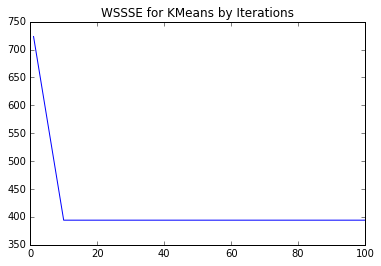

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot the error data
plt.plot(errors[:,0],errors[:,1])
plt.title("WSSSE for KMeans by Iterations")
plt.show()

#### <span style="color:violet"> We can see that by 10 iterations we have already converged and that more iterations do not really help us get to a more accurate set of centroids. </span>

<a name="HW10.4"><h2 style="color:darkblue"> HW10.4: KMeans Experiments (Homegrown)  </h2>
[Back to Table of Contents](#TOC)

Using this provided [homegrown Kmeans code](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb)   repeat the experiments in HW10.3. Explain any differences between the results in HW10.3 and HW10.4.
<br>
<br>
### <span style="color:violet"> I accidentally my own version based on the notebook rather than using the notebook straight up. </span>

### Load in and parse the data

In [33]:
import numpy as np

# load in the data file
data = sc.textFile("data.csv")

# parse the data by turning it into a list of floats
parsedData = data.map(lambda line: np.array([float(x) for x in line.split(',')])).cache()

# create the data in list form for plotting
data = np.array(parsedData.collect())

print "Data loaded."

Data loaded.


### Function to find nearest centroid

In [5]:
def findNearest(point,centroid_list):
    """function takes a point and a list of
    centroids and returns the index of the
    closest centroid"""
    
    # calculate distances between the point
    # and every centroid
    dist = np.sum((point - centroid_list)**2, axis=1)
    
    # the closest centroid is the one with
    # the minimum distance
    closest = dist.argmin()
    
    # return the closest centroid, the 
    # point, and 1
    return (closest,(point,1))

### Function to plot the data and the centroid

In [37]:
%matplotlib inline

# import our libraries
import matplotlib.pyplot as plt

def plotKMeans(centroids, data, \
               data_color = 'blue',\
               centroid_color = 'red'):
    """takes the centroid locations and the 
    data that we want to plot and plots the 
    points with the centroids in a different
    color"""    
    
    # plot the data
    plt.plot(data[:,0], data[:,1],'.', \
             color = data_color)
    
    # plot the centroids
    plt.plot(centroids[:,0], centroids[:,1], \
             '*', markersize =10, color = centroid_color)
    
    # show the plot
    plt.show()

### Function to calculate the WSSSE
This is the "Within Set Sum of Squared Error". It is the sum of the squared distances between each point and its predicted centroid. 

In [85]:
import numpy as np
from math import sqrt

# evaluate clustering by computing Within Set Sum 
# of Squared Errors the WSSSE is simply the distance
# between each point and its predicted centroid
def sqError(point,centroids):
    """where point = (closest,(point,1)) and
    centroids is a list of the centroid locations"""
    
    # get the values for the predicted centroid
    center_idx = point[0]
    center = np.array(centroids[center_idx])

    # set the point as purely its x,y coordinates
    point = point[1][0]
    
    # calculate the difference
    difference = point - center
    
    # square the difference 
    diff_sq = difference**2
    
    # sum the difference and return that
    sum_diff = sum(diff_sq)
    return sum_diff

### Initalize the first set of centroids

In [96]:
# set the number of clusters
K = 3

# initalize a first set of centroids
# set up an blank array to hold the 
# centroids
centroids = []

# loop through the number of centroids
for i in range(K):
    
    # generate a random point 
    # and add it to the centroid
    # list
    _center_idx = np.random.randint(0,len(parsedData.collect())-1)
    
    # grab that point
    _center = parsedData.collect()[_center_idx]
    
    # add it to the list
    centroids.append(_center)
    
# print out our first centroids
print "Initial centroids:"
print centroids

Initial centroids:
[array([ 0.99734353,  3.19877607]), array([-0.63718362,  4.21190538]), array([ 2.27737911,  1.21096427])]


### Iterate over the data, updating the centroids

Iteration 1
WSSSE: 1072.29146672
Centroids:
[[ 4.41760255  5.61339339]
 [ 4.50882985  0.89399402]
 [-0.60751464  4.49553226]]


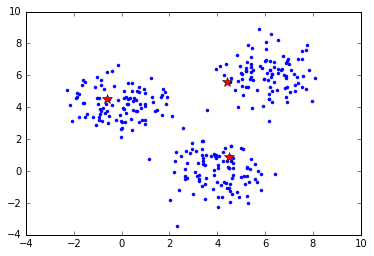



Iteration 10
WSSSE: 632.187200555
Centroids:
[[  6.10388592e+00   6.04617728e+00]
 [ -9.41177197e-02   4.24204239e+00]
 [  3.99865621e+00   4.49242347e-03]]


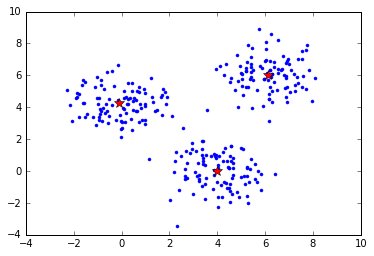



Iteration 20
WSSSE: 632.187200555
Centroids:
[[  6.10388592e+00   6.04617728e+00]
 [ -9.41177197e-02   4.24204239e+00]
 [  3.99865621e+00   4.49242347e-03]]


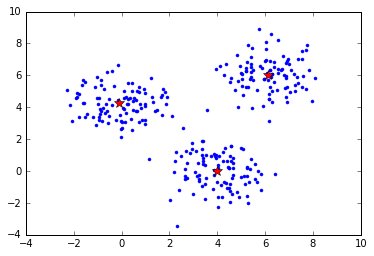



Iteration 100
WSSSE: 632.187200555
Centroids:
[[  6.10388592e+00   6.04617728e+00]
 [ -9.41177197e-02   4.24204239e+00]
 [  3.99865621e+00   4.49242347e-03]]


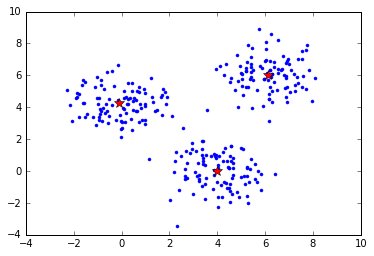

In [97]:
# set the number of iterations
ITERATIONS = 100

# set the interesting iterations
INTEREST = [1,10,20,100]

# set the iterations we want
# to record errors for
ERROR_INTEREST = [1, 10, 20, 30, 40, 50, 100]

# create a list to hold our 
# error for each iterations
errors = []

# set the current iteration
iteration = 0 

# while the iteration is less than 
# the number of iterations
while iteration <= ITERATIONS:
    
    # take each line of data and 
    # find its nearest neighbor
    _nearest = parsedData.map(lambda x: findNearest(x,centroids))
    
    # and then reduce by key
    # to get the sum of all points
    # and the number of data points
    _summed = _nearest.reduceByKey(lambda x,y: (x[0] + y[0], x[1] + y[1]))
    
    # and then reduce by dividing 
    # the sum of points by the 
    # total number of points
    new_centroids = _summed.map(lambda x: x[1][0]/x[1][1]).collect()
    
    # convert the new_centroids to 
    # numpy array
    centroids = np.array(new_centroids)
    
    # calculate the WSSE for this model by computing
    # the distance between each point and its assigned
    # centroid
    
    # first calculate the error for each point
    _error_each = _nearest.map(lambda x: sqError(x,centroids))

    # then calculate the total error
    _error_total = _error_each.reduce(lambda x,y: x+y)
    
    # increment the iterator
    iteration = iteration + 1
    
    # check to see if this is an iteration
    # where we want to record the error
    # if it is, then record it
    if iteration in ERROR_INTEREST:
        info = iteration,_error_total
        errors.append(info)
    
    # check to see if this an iteration
    # of interest, one that we would
    # like to plot
    if iteration in INTEREST:
        
        # print out the iteration 
        # and the centroids
        print "Iteration", iteration
        print "WSSSE:", _error_total
        print "Centroids:"
        print centroids

        # plot the centroids and the data
        plotKMeans(centroids,data)

        print "\n"
        
# convert the errors to a numpy array
# and write them to file
errors = np.array(errors)
np.savetxt('errors.csv',errors,delimiter = ',')

### Load in the error data

In [98]:
import numpy as np

# set the error from the text
errors = np.genfromtxt('errors.csv', delimiter=',')

# print out the file
print errors

[[  1.00000000e+00   1.07229147e+03]
 [  1.00000000e+01   6.32187201e+02]
 [  2.00000000e+01   6.32187201e+02]
 [  3.00000000e+01   6.32187201e+02]
 [  4.00000000e+01   6.32187201e+02]
 [  5.00000000e+01   6.32187201e+02]
 [  1.00000000e+02   6.32187201e+02]]


### Plot the error data

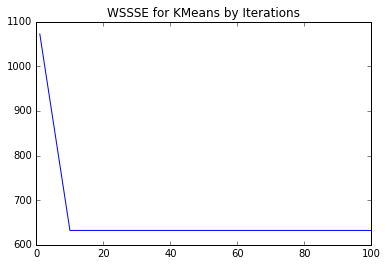

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot the error data
plt.plot(errors[:,0],errors[:,1])
plt.title("WSSSE for KMeans by Iterations")
plt.show()

#### <span style="color:violet"> We can see that by 10 iterations we have already converged and that more iterations do not really help us get to a more accurate set of centroids. </span>

<a name="HW10.4.1"><h2 style="color:darkblue"> HW10.4.1: Making Homegrown KMeans more efficient  </h2>
[Back to Table of Contents](#TOC)

The above provided homegrown KMeans implentation in not the most efficient. How can you make it more efficient? Make this change in the code and show it work and comment on the gains you achieve. 

### HINT: have a look at  [this linear regression notebook](    http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/atzqkc0p1eajuz6/LinearRegression-Notebook-Challenge.ipynb)

### <span style="color:violet">Broadcast the centroid data to the nodes</span>
<span style="color:violet">We broadcast the centroid data to the nodes so that it can be stored in memory and doesn't have to consistently be sent to each node over and over again. </span>

### Load in and parse the data

In [21]:
import numpy as np

# load in the data file
data = sc.textFile("data.csv")

# parse the data by turning it into a list of floats
parsedData = data.map(lambda line: np.array([float(x) for x in line.split(',')])).cache()

# create the data in list form for plotting
data = np.array(parsedData.collect())

print "Data loaded."

Data loaded.


### Function to plot the data and the centroid

In [23]:
%matplotlib inline

# import our libraries
import matplotlib.pyplot as plt

def plotKMeans(centroids, data, \
               data_color = 'blue',\
               centroid_color = 'red'):
    """takes the centroid locations and the 
    data that we want to plot and plots the 
    points with the centroids in a different
    color"""    
    
    # plot the data
    plt.plot(data[:,0], data[:,1],'.', \
             color = data_color)
    
    # plot the centroids
    plt.plot(centroids[:,0], centroids[:,1], \
             '*', markersize =10, color = centroid_color)
    
    # show the plot
    plt.show()

### Function to calculate the WSSSE
This is the "Within Set Sum of Squared Error". It is the sum of the squared distances between each point and its predicted centroid. 

In [24]:
import numpy as np
from math import sqrt

# evaluate clustering by computing Within Set Sum 
# of Squared Errors the WSSSE is simply the distance
# between each point and its predicted centroid
def sqError(point,centroids):
    """where point = (closest,(point,1)) and
    centroids is a list of the centroid locations"""
    
    # get the values for the predicted centroid
    center_idx = point[0]
    center = np.array(centroids[center_idx])

    # set the point as purely its x,y coordinates
    point = point[1][0]
    
    # calculate the difference
    difference = point - center
    
    # square the difference 
    diff_sq = difference**2
    
    # sum the difference and return that
    sum_diff = sum(diff_sq)
    return sum_diff

### Initalize the first set of centroids

In [33]:
# set the number of clusters
K = 3

# initalize a first set of centroids
# set up an blank array to hold the 
# centroids
centroids = []

# loop through the number of centroids
for i in range(K):
    
    # generate a random point 
    # and add it to the centroid
    # list
    _center_idx = np.random.randint(0,len(parsedData.collect())-1)
    
    # grab that point
    _center = parsedData.collect()[_center_idx]
    
    # add it to the list
    centroids.append(_center)
    
# convert centroids to numpy array
centroids = np.array(centroids)
    
# print out our first centroids
print "Initial centroids:"
print centroids

Initial centroids:
[[ 6.18021942  4.82217045]
 [ 5.22192418  6.29517308]
 [ 4.75215367  5.09329638]]


### Function to find nearest centroid

In [34]:
def findNearest(point,centroid_list):
    """function takes a point and a list of
    centroids and returns the index of the
    closest centroid"""
    print centroid_list
    # calculate distances between the point
    # and every centroid
    dist = np.sum((point - centroid_list)**2, axis=1)
    
    # the closest centroid is the one with
    # the minimum distance
    closest = dist.argmin()
    
    # return the closest centroid, the 
    # point, and 1
    return (closest,(point,1))

### Iterate over the data, updating the centroids

Iteration 1
WSSSE: 10187.953472
Centroids:
[[ 4.86426988  0.40754886]
 [ 6.12117402  6.26176499]
 [ 0.7817726   3.11179023]]


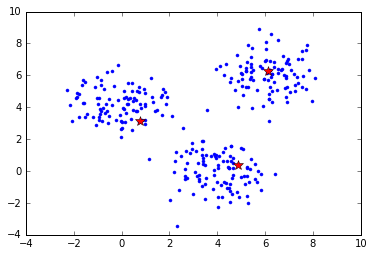



Iteration 10
WSSSE: 8910.89298252
Centroids:
[[ 4.01283697 -0.02271581]
 [-0.06737074  4.22687513]
 [ 6.10388592  6.04617728]]


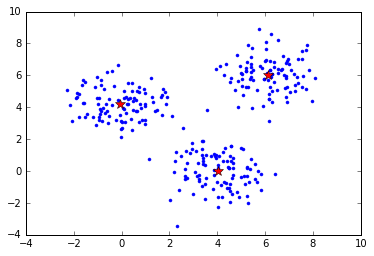



Iteration 20
WSSSE: 8910.89298252
Centroids:
[[ 4.01283697 -0.02271581]
 [-0.06737074  4.22687513]
 [ 6.10388592  6.04617728]]


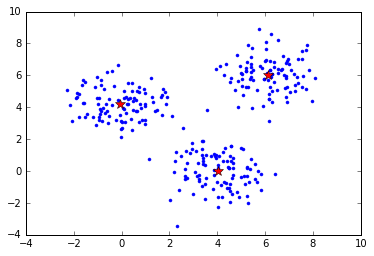



Iteration 100
WSSSE: 8910.89298252
Centroids:
[[ 4.01283697 -0.02271581]
 [-0.06737074  4.22687513]
 [ 6.10388592  6.04617728]]


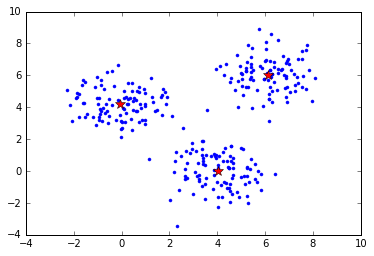

In [36]:
# set the number of iterations
ITERATIONS = 100

# set the interesting iterations
INTEREST = [1,10,20,100]

# set the iterations we want
# to record errors for
ERROR_INTEREST = [1, 10, 20, 30, 40, 50, 100]

# create a list to hold our 
# error for each iterations
errors = []

# set the current iteration
iteration = 0 

# while the iteration is less than 
# the number of iterations
while iteration <= ITERATIONS:
    
    # broadcast the centroids to each node
    broad_centroids = sc.broadcast(centroids)
    
    # take each line of data and 
    # find its nearest neighbor
    _nearest = parsedData.map(lambda x: findNearest(x,np.array(broad_centroids.value)))
    
    # and then reduce by key
    # to get the sum of all points
    # and the number of data points
    _summed = _nearest.reduceByKey(lambda x,y: (x[0] + y[0], x[1] + y[1]))
    
    # and then reduce by dividing 
    # the sum of points by the 
    # total number of points
    new_centroids = _summed.map(lambda x: x[1][0]/x[1][1]).collect()
    
    # convert the new_centroids to 
    # numpy array
    centroids = np.array(new_centroids)
    
    # calculate the WSSE for this model by computing
    # the distance between each point and its assigned
    # centroid
    
    # first calculate the error for each point
    _error_each = _nearest.map(lambda x: sqError(x,centroids))

    # then calculate the total error
    _error_total = _error_each.reduce(lambda x,y: x+y)
    
    # increment the iterator
    iteration = iteration + 1
    
    # check to see if this is an iteration
    # where we want to record the error
    # if it is, then record it
    if iteration in ERROR_INTEREST:
        info = iteration,_error_total
        errors.append(info)
    
    # check to see if this an iteration
    # of interest, one that we would
    # like to plot
    if iteration in INTEREST:
        
        # print out the iteration 
        # and the centroids
        print "Iteration", iteration
        print "WSSSE:", _error_total
        print "Centroids:"
        print centroids

        # plot the centroids and the data
        plotKMeans(centroids,data)

        print "\n"
        
# convert the errors to a numpy array
# and write them to file
errors = np.array(errors)
np.savetxt('errors.csv',errors,delimiter = ',')

### Load in the error data

In [37]:
import numpy as np

# set the error from the text
errors = np.genfromtxt('errors.csv', delimiter=',')

# print out the file
print errors

[[  1.00000000e+00   1.01879535e+04]
 [  1.00000000e+01   8.91089298e+03]
 [  2.00000000e+01   8.91089298e+03]
 [  3.00000000e+01   8.91089298e+03]
 [  4.00000000e+01   8.91089298e+03]
 [  5.00000000e+01   8.91089298e+03]
 [  1.00000000e+02   8.91089298e+03]]


### Plot the error data

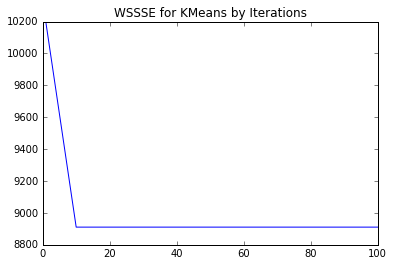

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot the error data
plt.plot(errors[:,0],errors[:,1])
plt.title("WSSSE for KMeans by Iterations")
plt.show()

#### <span style="color:violet"> We can see that by 10 iterations we have already converged and that more iterations do not really help us get to a more accurate set of centroids. </span>

<a name="HW10.5"><h2 style="color:darkgreen"> HW10.5: OPTIONAL Weighted KMeans  </h2>
[Back to Table of Contents](#TOC)

Using this provided [homegrown Kmeans code](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb), modify it to do a weighted KMeans and repeat the experiements in HW10.3. Explain  any differences between the results in HW10.3 and HW10.5.

NOTE: Weight each example as follows using the inverse vector length (Euclidean norm): 

> weight(X)= 1/||X||, 

where ||X|| = SQRT(X.X)= SQRT(X1^2 + X2^2)

Here X is vector made up of two values X1 and X2.

__[Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__

In [71]:
## Code goes here

In [72]:
## Drivers & Runners

In [73]:
## Run Scripts, S3 Sync

<a name="HW10.6"><h2 style="color:darkblue"> HW10.6 OPTIONAL Linear Regression</h2>
[Back to Table of Contents](#TOC)
<a name="HW10.6.1"><h2 style="color:darkblue"> HW10.6.1 OPTIONAL Linear Regression</h2>
[Back to Table of Contents](#TOC)

Using [this linear regression notebook](    http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/atzqkc0p1eajuz6/LinearRegression-Notebook-Challenge.ipynb):


* Generate 2 sets of data with 100 data points using the data generation code provided and plot each in separate plots. Call one the training set and the other the testing set.

* Using MLLib's LinearRegressionWithSGD train up a linear regression model with the training dataset and evaluate with the testing set. What a good number of iterations for training the linear regression model? Justify with plots (e.g., plot MSE as a function of the number of iterations) and words. 


<a name="HW10.6.2"><h2 style="color:darkblue"> HW10.6.2 OPTIONAL Linear Regression</h2>
[Back to Table of Contents](#TOC)

In the notebook provided above, in the cell labeled "Gradient descent (regularization)".

* Fill in the blanks and get this code to work for LASS0 and RIDGE linear regression.

* Using the data from HW10.6.1 tune the hyper parameters of your LASS0 and RIDGE regression. Report your findings with words and plots.

In [74]:
## Code goes here

In [75]:
## Drivers & Runners

In [76]:
## Run Scripts, S3 Sync

<a name="HW10.7"><h2 style="color:darkgreen"> HW10.7 OPTIONAL Error surfaces </h2>
[Back to Table of Contents](#TOC)

Here is a link to R code with 1 test drivers that plots the linear regression model in  model space and in the domain space:

> https://www.dropbox.com/s/3xc3kwda6d254l5/PlotModelAndDomainSpaces.R?dl=0

Here is a sample output from this script: 
      
> https://www.dropbox.com/s/my3tnhxx7fr5qs0/image%20%281%29.png?dl=0

Please use this as inspiration and code a equivalent error surface and heatmap (with isolines) in Spark and show the trajectory of learning taken during gradient descent(after each n-iterations of Gradient Descent):


Using Spark and  Python (using the above R Script as inspiration), plot the error surface for the linear regression model using a heatmap and contour plot. 
Also plot the current model in the original domain space for every 10th iteration.  Plot them side by side if possible  for each iteration: lefthand side plot is the model space(w0 and w01) and the righthand side plot is domain space (plot the corresponding model and training data in the problem domain space) with a final pair of graphs showing the entire trajectory in the model and domain space. Make sure to label your plots with iteration numbers, function, model space versus original domain space, MSE on the training data etc.

Also plot the MSE as a function of each iteration (possibly every 10th iteration). Dont forget to label both axis and the graph also. __[Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__





In [77]:
## Code goes here

In [78]:
## Drivers & Runners

In [79]:
## Run Scripts, S3 Sync

[Back to Table of Contents](#TOC)
<center><div class='jumbotron'><h2 style='color:green'>-------  END OF HOWEWORK --------</h2></div></center>